# -------------Giai đoạn 1: Xử lí dữ liệu-------------

* Khai báo thư viện

In [49]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import spacy
from collections import Counter
import io
import os

# 1. Load Tokenizer (Spacy)

In [50]:
!python -m spacy download fr_core_news_sm
spacy_en = spacy.load("en_core_web_sm")
spacy_fr = spacy.load("fr_core_news_sm")

def tokenize_en(text):
    """Tách từ tiếng Anh, đảo ngược nếu cần (nhưng lúc này cứ để xuôi đê)"""
    return [tok.text.lower() for tok in spacy_en.tokenizer(text)]

def tokenize_fr(text):
    """Tách từ tiếng Pháp"""
    return [tok.text.lower() for tok in spacy_fr.tokenizer(text)]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 126.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# 2. Xây dựng bộ từ vựng (Vocabulary)

In [51]:
class Vocabulary:
    def __init__(self, freq_threshold=2):
        # 4 token đặc biệt bắt buộc phải có
        self.itos = {0: "<unk>", 1: "<pad>", 2: "<sos>", 3: "<eos>"}
        self.stoi = {"<unk>": 0, "<pad>": 1, "<sos>": 2, "<eos>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    def build_vocabulary(self, sentence_list, tokenizer):
        frequencies = Counter()
        idx = 4 # Bắt đầu từ 4 vì 0-3 đã dùng cho token đặc biệt

        for sentence in sentence_list:
            for word in tokenizer(sentence):
                frequencies[word] += 1

                # Chỉ thêm từ xuất hiện đủ nhiều (tránh rác)
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text, tokenizer):
        """Chuyển câu text thành list các số (indices)"""
        tokenized_text = tokenizer(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<unk>"]
            for token in tokenized_text
        ]

# 3. Class Dataset Chính

In [52]:
class Multi30kDataset(Dataset):
    def __init__(self, root_dir, mode='train', src_vocab=None, trg_vocab=None):
        self.root_dir = root_dir
        self.mode = mode

        # Đọc file raw
        en_path = os.path.join(root_dir, f'{mode}.en')
        fr_path = os.path.join(root_dir, f'{mode}.fr')

        with open(en_path, 'r', encoding='utf-8') as f:
            self.source_sentences = [line.strip() for line in f.readlines()]

        with open(fr_path, 'r', encoding='utf-8') as f:
            self.target_sentences = [line.strip() for line in f.readlines()]

        # Xây dựng hoặc dùng lại vocab
        if src_vocab is None or trg_vocab is None:
            print(f" Đang xây dựng Vocabulary từ tập {mode}...")
            self.src_vocab = Vocabulary()
            self.trg_vocab = Vocabulary()

            self.src_vocab.build_vocabulary(self.source_sentences, tokenize_en)
            self.trg_vocab.build_vocabulary(self.target_sentences, tokenize_fr)
            print(f" Vocab xong! Tiếng Anh: {len(self.src_vocab)} từ, Tiếng Pháp: {len(self.trg_vocab)} từ.")
        else:
            self.src_vocab = src_vocab
            self.trg_vocab = trg_vocab

    def __len__(self):
        return len(self.source_sentences)

    def __getitem__(self, index):
        src_text = self.source_sentences[index]
        trg_text = self.target_sentences[index]

        # Chuyển text sang số: <sos> ...câu... <eos>
        src_numericalized = [self.src_vocab.stoi["<sos>"]]
        src_numericalized += self.src_vocab.numericalize(src_text, tokenize_en)
        src_numericalized += [self.src_vocab.stoi["<eos>"]]

        trg_numericalized = [self.trg_vocab.stoi["<sos>"]]
        trg_numericalized += self.trg_vocab.numericalize(trg_text, tokenize_fr)
        trg_numericalized += [self.trg_vocab.stoi["<eos>"]]

        return torch.tensor(src_numericalized), torch.tensor(trg_numericalized)

# 4. Hàm Collate (Xử lý Batch - QUAN TRỌNG NHẤT)

In [53]:
class Collate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        # batch là list các cặp (src, trg) từ __getitem__

        # Sắp xếp batch theo độ dài câu nguồn giảm dần (Bắt buộc cho pack_padded_sequence)
        batch.sort(key=lambda x: len(x[0]), reverse=True)

        src_batch, trg_batch = zip(*batch)

        # Padding: thêm số 1 (<pad>) vào cho bằng độ dài
        src_padded = pad_sequence(src_batch, padding_value=self.pad_idx, batch_first=False) # Shape: [src_len, batch_size]
        trg_padded = pad_sequence(trg_batch, padding_value=self.pad_idx, batch_first=False) # Shape: [trg_len, batch_size]

        return src_padded, trg_padded

# --------------GIAI ĐOẠN 2: XÂY DỰNG MODEL------------------

* Khai báo thêm thư viện

In [54]:
import torch
import torch.nn as nn
import random

# 1. Mã hóa lớp Encoder

In [55]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        # Chuyển từ (số) sang vector
        self.embedding = nn.Embedding(input_dim, emb_dim)

        # LSTM: input_size=emb_dim, hidden_size=hid_dim
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)

        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src shape: [src len, batch size]

        embedded = self.dropout(self.embedding(src))
        # embedded shape: [src len, batch size, emb dim]

        outputs, (hidden, cell) = self.rnn(embedded)

        # outputs: chứa hidden state của tất cả các time step (dùng cho Attention sau này)
        # hidden, cell: trạng thái ẩn cuối cùng (Context Vector) -> Cần cho Decoder
        return hidden, cell

# 2. Giải mã (Decoder)

In [56]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        # Embedding cho Target (Tiếng Pháp)
        self.embedding = nn.Embedding(output_dim, emb_dim)

        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)

        # Linear layer để dự đoán từ tiếp theo
        self.fc_out = nn.Linear(hid_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        # input shape: [batch size] (chỉ 1 từ tại 1 thời điểm)
        # hidden, cell: context vector từ bước trước

        input = input.unsqueeze(0)
        # input shape: [1, batch size]

        embedded = self.dropout(self.embedding(input))
        # embedded shape: [1, batch size, emb dim]

        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        # output shape: [1, batch size, hid dim]

        prediction = self.fc_out(output.squeeze(0))
        # prediction shape: [batch size, output dim]

        return prediction, hidden, cell

# 3. Tạo mô hình Seq2Seq kết hợp Encoder và Decoder

In [57]:
class MyTranslationModel(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        # Check size cho chắc cú
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src: [src len, batch size]
        # trg: [trg len, batch size]

        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        # Tensor chứa kết quả dự đoán
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        # 1. Mã hóa câu nguồn (Encoder) -> Lấy context vector (hidden, cell)
        hidden, cell = self.encoder(src)

        # 2. Đầu vào đầu tiên cho Decoder là token <sos> (Start of Sentence)
        input = trg[0, :]

        # 3. Vòng lặp giải mã từng từ (Decoder)
        for t in range(1, trg_len):
            # Chạy 1 bước decoder
            output, hidden, cell = self.decoder(input, hidden, cell)

            # Lưu dự đoán vào tensor outputs
            outputs[t] = output

            # Quyết định Teacher Forcing:
            # Nếu random < ratio -> dùng từ thật (target) làm input tiếp theo
            # Ngược lại -> dùng từ dự đoán cao nhất (top1) làm input tiếp theo
            teacher_force = random.random() < teacher_forcing_ratio

            top1 = output.argmax(1)

            input = trg[t] if teacher_force else top1

        return outputs


# --- TEST THỬ MODEL ---

In [58]:
if __name__ == "__main__":
    # Giả lập tham số
    INPUT_DIM = 1000
    OUTPUT_DIM = 1000
    ENC_EMB_DIM = 256
    DEC_EMB_DIM = 256
    HID_DIM = 512
    N_LAYERS = 2
    ENC_DROPOUT = 0.5
    DEC_DROPOUT = 0.5
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
    dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
    model = MyTranslationModel(enc, dec, DEVICE).to(DEVICE)

    # Giả lập input (như output của Dataset nãy chạy)
    src = torch.randint(0, 1000, (24, 32)).to(DEVICE) # [Src Len, Batch Size]
    trg = torch.randint(0, 1000, (26, 32)).to(DEVICE) # [Trg Len, Batch Size]

    print(" Đang chạy thử model qua 1 vòng forward...")
    output = model(src, trg)
    print(f" Output Shape: {output.shape}")
    # Mong đợi: [26, 32, 1000] -> [Trg Len, Batch Size, Output Dim]

 Đang chạy thử model qua 1 vòng forward...
 Output Shape: torch.Size([26, 32, 1000])


 Đang chạy trên: cuda
 Đang load dữ liệu...
 Đang xây dựng Vocabulary từ tập train...
 Vocab xong! Tiếng Anh: 5893 từ, Tiếng Pháp: 6470 từ.
 Data ngon lành! Train: 29000, Val: 3
 Đang đọc dữ liệu từ data_clean...
 Đang xây dựng Vocabulary từ tập train...
 Vocab xong! Tiếng Anh: 5893 từ, Tiếng Pháp: 6470 từ.
 Số lượng câu Train: 29000
 Số lượng câu Val:   3
 Vocab Size: Anh=5893, Pháp=6470

 Bắt đầu Train 10 epochs (Dữ liệu thật)...
   Batch 0/907 | Loss: 8.771
   Batch 50/907 | Loss: 5.255
   Batch 100/907 | Loss: 5.108
   Batch 150/907 | Loss: 5.042
   Batch 200/907 | Loss: 4.952
   Batch 250/907 | Loss: 4.729
   Batch 300/907 | Loss: 5.042
   Batch 350/907 | Loss: 4.790
   Batch 400/907 | Loss: 4.493
   Batch 450/907 | Loss: 4.436
   Batch 500/907 | Loss: 4.598
   Batch 550/907 | Loss: 4.503
   Batch 600/907 | Loss: 3.871
   Batch 650/907 | Loss: 4.379
   Batch 700/907 | Loss: 4.379
   Batch 750/907 | Loss: 4.365
   Batch 800/907 | Loss: 4.167
   Batch 850/907 | Loss: 3.996
   Batch 

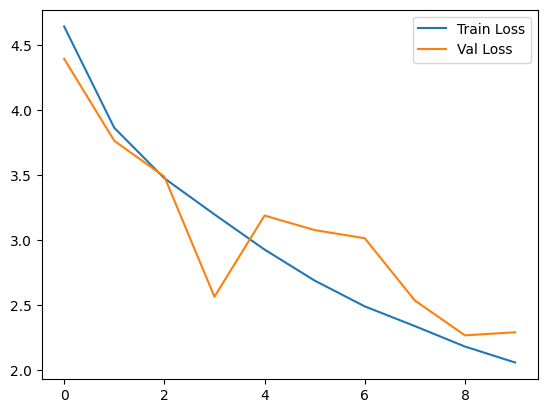


 Dịch thử 1 câu:
Src: A man is walking a dog.
Trg: un chien promène un chien .


In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import math
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Import mấy cái class nãy giờ mình viết (Giả sử mày để chung 1 file hoặc import từ file khác)
# from data_loader import Multi30kDataset, Collate
# from model import Encoder, Decoder, Seq2Seq

# --- CẤU HÌNH (CONFIG) ---
DATA_DIR = "./data_clean" # Folder chứa data chuẩn
BATCH_SIZE = 32         # CPU yếu thì để 32 hoặc 16 thôi
N_EPOCHS = 10           # Chạy thử 5-10 epoch xem sao
CLIP = 1.0              # Cắt gradient để không bị lỗi
LR = 0.001              # Tốc độ học

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Đang chạy trên: {DEVICE}")

# --- 1. CHUẨN BỊ DỮ LIỆU ---
print(" Đang load dữ liệu...")
train_dataset = Multi30kDataset(DATA_DIR, mode='train')
val_dataset = Multi30kDataset(DATA_DIR, mode='val', src_vocab=train_dataset.src_vocab, trg_vocab=train_dataset.trg_vocab)
# test_dataset = Multi30kDataset(DATA_DIR, mode='test', src_vocab=train_dataset.src_vocab, trg_vocab=train_dataset.trg_vocab)

pad_idx = train_dataset.src_vocab.stoi["<pad>"]

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=Collate(pad_idx), num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=Collate(pad_idx), num_workers=0)

print(f" Data ngon lành! Train: {len(train_dataset)}, Val: {len(val_dataset)}")

# --- 2. KHỞI TẠO MODEL ---
INPUT_DIM = len(train_dataset.src_vocab)
OUTPUT_DIM = len(train_dataset.trg_vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model = MyTranslationModel(enc, dec, DEVICE).to(DEVICE)

# Khởi tạo trọng số (Weight Initialization) - Giúp model học nhanh hơn
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
model.apply(init_weights)

optimizer = optim.Adam(model.parameters(), lr=LR)
# Bỏ qua loss của token <pad>
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

# --- 3. HÀM TRAIN & EVALUATE ---
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0

    for i, (src, trg) in enumerate(iterator):
        src, trg = src.to(DEVICE), trg.to(DEVICE)

        optimizer.zero_grad()

        # output: [trg len, batch size, output dim]
        output = model(src, trg)

        output_dim = output.shape[-1]

        # Bỏ token <sos> đầu tiên khi tính loss
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)
        loss.backward()

        # Clip gradient để tránh bùng nổ
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()
        epoch_loss += loss.item()

        # Log nhẹ cái để biết máy không bị treo (mỗi 50 batch báo 1 lần)
        if i % 50 == 0:
            print(f"   Batch {i}/{len(iterator)} | Loss: {loss.item():.3f}")

    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, (src, trg) in enumerate(iterator):
            src, trg = src.to(DEVICE), trg.to(DEVICE)
            output = model(src, trg, teacher_forcing_ratio=0) # Tắt teacher forcing khi val/test
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

# --- 4. HÀM DỊCH THỬ (LẤY ĐIỂM) ---
def translate_sentence(sentence, src_vocab, trg_vocab, model, device, max_len=50):
    model.eval()

    # 1. Tokenize & Numericalize
    if isinstance(sentence, str):
        import spacy
        spacy_en = spacy.load("en_core_web_sm")
        tokens = [token.text.lower() for token in spacy_en(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = ["<sos>"] + tokens + ["<eos>"]
    src_indexes = [src_vocab.stoi.get(token, src_vocab.stoi["<unk>"]) for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device) # [len, 1]

    with torch.no_grad():
        # Encoder
        hidden, cell = model.encoder(src_tensor)

    # Decoder
    trg_indexes = [trg_vocab.stoi["<sos>"]]

    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device) # [1]

        with torch.no_grad():
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell)

        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)

        if pred_token == trg_vocab.stoi["<eos>"]:
            break

    trg_tokens = [trg_vocab.itos[i] for i in trg_indexes]
    return trg_tokens[1:-1] # Bỏ sos, eos

# --- 5. VÒNG LẶP CHÍNH (MAIN LOOP) ---
if __name__ == "__main__":
    import os

    # 1. CẤU HÌNH
    DATA_DIR = "data_clean"

    # --- KIỂM TRA AN TOÀN ---
    # Nếu không thấy data thì báo lỗi dừng lại, CHỨ KHÔNG TỰ TẠO FILE MỚI NỮA
    if not os.path.exists(os.path.join(DATA_DIR, 'train.en')):
        print(" LỖI TO: Không tìm thấy file dữ liệu!")
        print(" Chạy lại Bước 1 (Cell Cứu Hộ) để tải data về đã!")
        exit() # Dừng chương trình ngay lập tức

    # 2. Load Dataset (Chỉ đọc)
    print(f" Đang đọc dữ liệu từ {DATA_DIR}...")
    train_dataset = Multi30kDataset(DATA_DIR, mode='train')
    val_dataset = Multi30kDataset(DATA_DIR, mode='val', src_vocab=train_dataset.src_vocab, trg_vocab=train_dataset.trg_vocab)

    # Kiểm tra số lượng (Phải ~29000 mới đúng)
    print(f" Số lượng câu Train: {len(train_dataset)}")
    print(f" Số lượng câu Val:   {len(val_dataset)}")
    print(f" Vocab Size: Anh={len(train_dataset.src_vocab)}, Pháp={len(train_dataset.trg_vocab)}")

    # 3. Setup DataLoader
    pad_idx = train_dataset.src_vocab.stoi["<pad>"]
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=Collate(pad_idx), num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=Collate(pad_idx), num_workers=0)

    # 4. Khởi tạo Model
    INPUT_DIM = len(train_dataset.src_vocab)
    OUTPUT_DIM = len(train_dataset.trg_vocab)

    enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
    dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
    model = MyTranslationModel(enc, dec, DEVICE).to(DEVICE)

    def init_weights(m):
        for name, param in m.named_parameters():
            nn.init.uniform_(param.data, -0.08, 0.08)
    model.apply(init_weights)

    optimizer = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

    # 5. Bắt đầu Train
    best_valid_loss = float('inf')
    train_losses = []
    val_losses = []

    print(f"\n Bắt đầu Train {N_EPOCHS} epochs (Dữ liệu thật)...")

    for epoch in range(N_EPOCHS):
        start_time = time.time()

        train_loss = train(model, train_loader, optimizer, criterion, CLIP)
        valid_loss = evaluate(model, val_loader, criterion)

        end_time = time.time()
        epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

        train_losses.append(train_loss)
        val_losses.append(valid_loss)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"     Đã lưu model tốt nhất (Val Loss: {valid_loss:.3f})")

        print(f'Epoch: {epoch+1:02} | Time: {int(epoch_mins)}m {int(epoch_secs)}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f}')

    # 6. Vẽ biểu đồ & Test
    print("\n Đang vẽ biểu đồ Loss...")
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.savefig('loss_chart.png')
    plt.show()

    model.load_state_dict(torch.load('best_model.pth'))
    print("\n Dịch thử 1 câu:")
    sentence = "A man is walking a dog."
    translation = translate_sentence(sentence, train_dataset.src_vocab, train_dataset.trg_vocab, model, DEVICE)
    print(f"Src: {sentence}")
    print(f"Trg: {' '.join(translation)}")